# This script demonstrates how to train a M²VAE with a split MNIST data set and evaluate the Hyperparameter

In [60]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import glob
import pickle

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.2
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


In [61]:
#TODO move to loader

# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Cut down data set for testing
#x_train = x_train[:10,:]
#y_train = y_train[:10]
#x_test = x_test[:10,:]
#y_test = y_test[:10]

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
original_dim = img_rows * img_cols * img_chns
split_dim = int(original_dim / 2)

# Split it horizontally
x_train_a = x_train[:,:split_dim]
x_train_b = x_train[:,split_dim:]
x_test_a = x_test[:,:split_dim]
x_test_b = x_test[:,split_dim:]

# Show a split image

#f, ax = plt.subplots(2,1,sharex=True)
#ax[0].imshow(x_train_a[0,:].reshape(((int(img_rows/2), img_cols))))
#ax[1].imshow(x_train_b[0,:].reshape(((int(img_rows/2), img_cols))))
#plt.show()


In [62]:
dump_loc = '/mnt/ssd_pcie/mmvae_mnist_split/0/'

df = pd.read_hdf(dump_loc + 'history.h5', key='df', mode='r+')
#df


Opening /mnt/ssd_pcie/mmvae_mnist_split/0/history.h5 in read-only mode


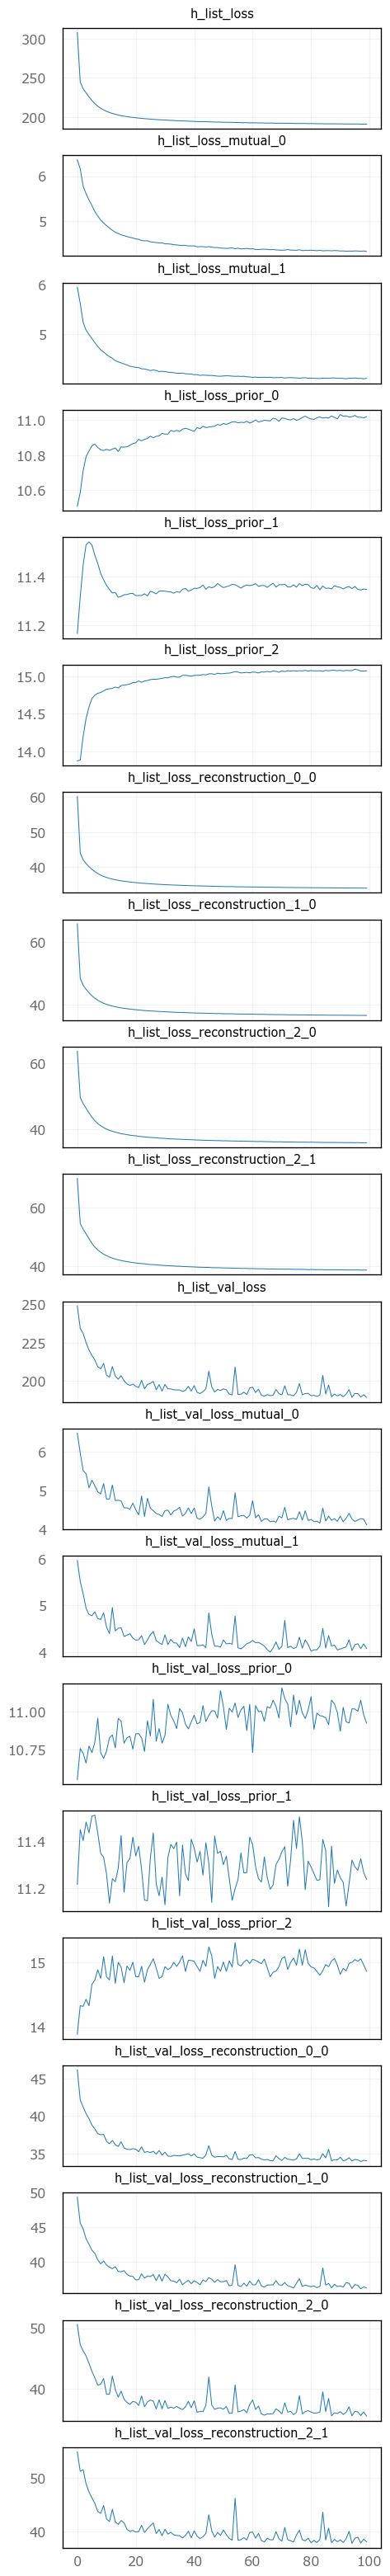

In [63]:
#df.columns
#df['h*'].columns
idx = 1
hist = tf.keras.callbacks.History()
hist.history = df[[c for c in df.columns if c[:6]=='h_list']].to_dict('records')[idx]
vae_tools.viz.plot_losses(hist, dpi=96, figsize_height_factor = .325)
plt.show()
#hist.history

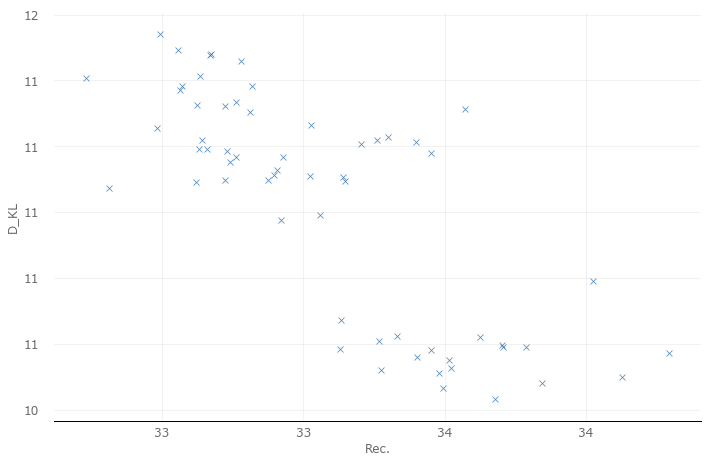

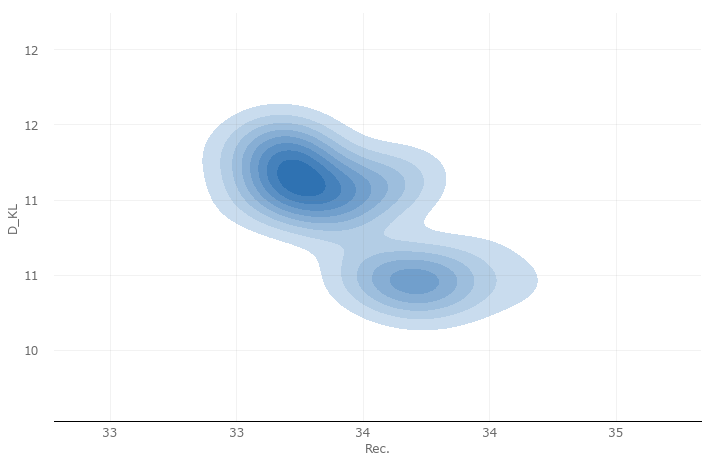

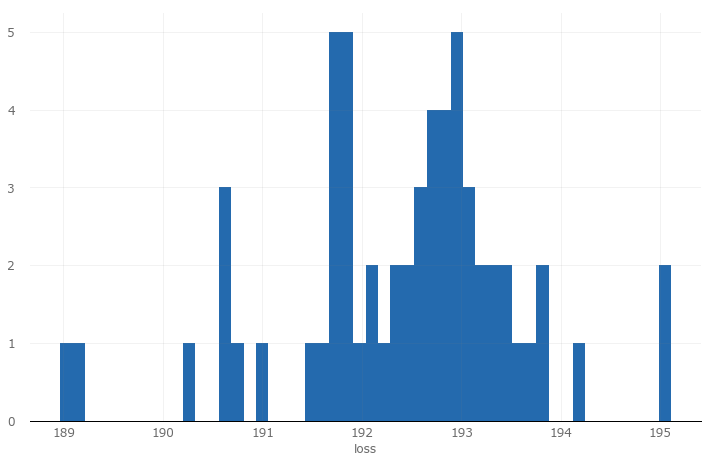

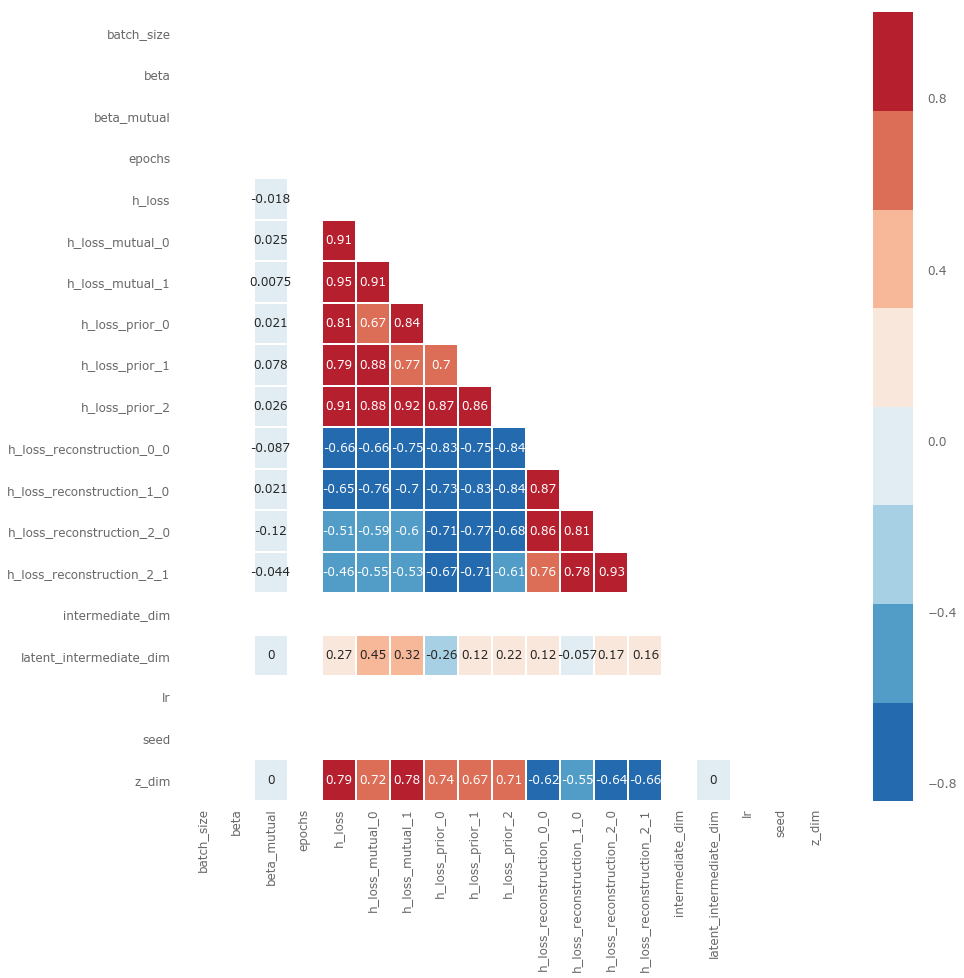

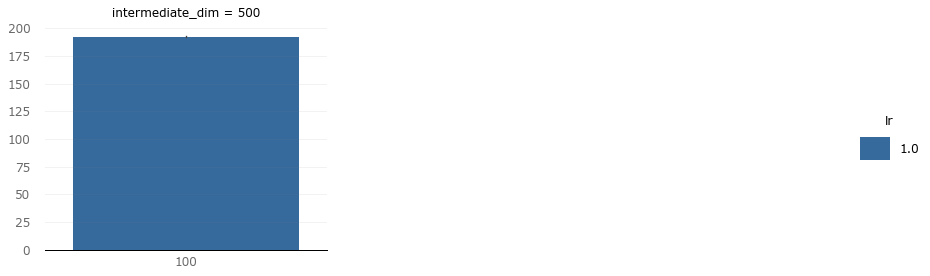

In [64]:
h_prefix = 'h_'
import astetik
%matplotlib inline

# a regression plot for two dimensions
astetik.regs(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# up to two dimensional kernel density estimator
astetik.kde(df, x=h_prefix + 'val_loss_reconstruction_0_0', y=h_prefix + 'val_loss_prior_0', x_label='Rec.', y_label='D_KL')
# a simple histogram
astetik.hist(df, h_prefix + 'val_loss',bins=50, x_label='loss')
# correlation w/o validation
_df = df.drop(["activation","reconstruction_loss_metrics","optimizer","index"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]
astetik.corr(_df, color_grades=5, style='astetik', annot=True)
# a four dimensional bar grid
astetik.bargrid(df, x='batch_size', y=h_prefix + 'val_loss', hue='lr', col='intermediate_dim',  col_wrap=3)



In [65]:
# Get the models and predict all data
model_enc_mean, _ = vae_tools.vae.GenericVae.load_model_powerset(dump_loc + 'enc_mean_' + str(idx) + '_ab_', 2)
model_enc_logvar, _ = vae_tools.vae.GenericVae.load_model_powerset(dump_loc + 'enc_logvar_' + str(idx) + '_ab_', 2)


model_enc_mean_a = model_enc_mean[0]
model_enc_mean_b = model_enc_mean[1]
model_enc_mean_ab = model_enc_mean[2]

model_enc_logvar_a = model_enc_logvar[0]
model_enc_logvar_b = model_enc_logvar[1]
model_enc_logvar_ab = model_enc_logvar[2]

z_train_ab = model_enc_mean_ab.predict([x_train_a, x_train_b])
z_train_a = model_enc_mean_a.predict(x_train_a)
z_train_b = model_enc_mean_b.predict(x_train_b)

z_test_ab = model_enc_mean_ab.predict([x_test_a, x_test_b])
z_test_a = model_enc_mean_a.predict(x_test_a)
z_test_b = model_enc_mean_b.predict(x_test_b)

z_train_logvar_ab = model_enc_logvar_ab.predict([x_train_a, x_train_b])
z_train_logvar_a = model_enc_logvar_a.predict(x_train_a)
z_train_logvar_b = model_enc_logvar_b.predict(x_train_b)

z_test_logvar_ab = model_enc_logvar_ab.predict([x_test_a, x_test_b])
z_test_logvar_a = model_enc_logvar_a.predict(x_test_a)
z_test_logvar_b = model_enc_logvar_b.predict(x_test_b)

Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_mean_1_ab_10 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_mean_1_ab_01 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_mean_1_ab_11 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_logvar_1_ab_10 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_logvar_1_ab_01 from disk
Loaded model /mnt/ssd_pcie/mmvae_mnist_split/0/enc_logvar_1_ab_11 from disk


## Train a naive Bayesian Classifier

In [66]:
#from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

#X, y = load_iris(return_X_y=True)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb_ab = GaussianNB().fit(z_train_ab, y_train)
y_pred_ab_ab = gnb_ab.predict(z_test_ab)
y_pred_ab_a = gnb_ab.predict(z_test_a)
y_pred_ab_b = gnb_ab.predict(z_test_b)
print("")
print("Train ab, test on %d points." %(y_test.shape[0]))
print("mislabeled in ab : %d" % ((y_test != y_pred_ab_ab).sum()))
print("mislabeled in a  : %d" % ((y_test != y_pred_ab_a).sum()))
print("mislabeled in b  : %d" % ((y_test != y_pred_ab_b).sum()))


Train ab, test on 10000 points.
mislabeled in ab : 1112
mislabeled in a  : 1614
mislabeled in b  : 1955


In [67]:
gnb_a = GaussianNB().fit(z_train_a, y_train)
y_pred_a_ab = gnb_a.predict(z_test_ab)
y_pred_a_a = gnb_a.predict(z_test_a)
y_pred_a_b = gnb_a.predict(z_test_b)

print("")
print("Train a, test on %d points." %(y_test.shape[0]))
print("mislabeled in ab : %d" % ((y_test != y_pred_a_ab).sum()))
print("mislabeled in a  : %d" % ((y_test != y_pred_a_a).sum()))
print("mislabeled in b  : %d" % ((y_test != y_pred_a_b).sum()))


Train a, test on 10000 points.
mislabeled in ab : 1651
mislabeled in a  : 1564
mislabeled in b  : 2508


In [68]:
gnb_b = GaussianNB().fit(z_train_b, y_train)
y_pred_b_ab = gnb_b.predict(z_test_ab)
y_pred_b_a = gnb_b.predict(z_test_a)
y_pred_b_b = gnb_b.predict(z_test_b)

print("")
print("Train b, test on %d points." %(y_test.shape[0]))
print("mislabeled in ab : %d" % ((y_test != y_pred_b_ab).sum()))
print("mislabeled in a  : %d" % ((y_test != y_pred_b_a).sum()))
print("mislabeled in b  : %d" % ((y_test != y_pred_b_b).sum()))


Train b, test on 10000 points.
mislabeled in ab : 2003
mislabeled in a  : 2566
mislabeled in b  : 1955


## KL and JS Losses

In [78]:
def rel_bar_plot(metric, label, prediction, min, max, bins, ax, wlabel='wrong', clabel='correct'):
    ''' Plot relative bar chart with correct and wrong classifications

    :param metric: 1D array with a metric for each sample
    :param label: 1D array with ground truth label for each sample
    :param prediction: 1D array with predicted label for each sample
    :param min: scalar minimum value of histogram
    :param max: scalar maximum value of histogram
    :param bins: number of bins
    :param ax: axis for plotting
    :param wlabel: string label for correct classified samples
    :param clabel: string label for wrong classified samples
    '''
    mw = metric[(label != prediction)]
    mc = metric[(label == prediction)]
    h_cw, edges = np.histogram(metric, bins, range=(min, max))
    h_c, edges = np.histogram(mc, bins, range=(min, max))
    h_w, edges = np.histogram(mw, bins, range=(min, max))

    # Format the values
    skip = edges[1]-edges[0]
    barWidth = skip*0.9
    x = [r+skip/2. for r in edges[:-1]]
    h_c = h_c / h_cw
    h_w = h_w / h_cw

    #raw_data = {'correct': h_c, 'wrong': h_w}
    #df = pd.DataFrame(raw_data)
    ax.bar(x, h_w, color='#f9bc86', edgecolor='white', width=barWidth, label=wlabel)
    ax.bar(x, h_c, bottom=h_w, color='#b5ffb9', edgecolor='white', width=barWidth, label=clabel)
    ax.set_xlim((min, max))

### KL

In [79]:
kl_ab_ab = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_ab, z_test_logvar_ab, z_test_logvar_a)
kl_ab_a = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_a, z_test_logvar_ab, z_test_logvar_a)
kl_ab_b = vae_tools.metrics.kl_sym_loss(z_test_ab, z_test_b, z_test_logvar_ab, z_test_logvar_b)
kl_a_b = vae_tools.metrics.kl_sym_loss(z_test_a, z_test_b, z_test_logvar_a, z_test_logvar_b)

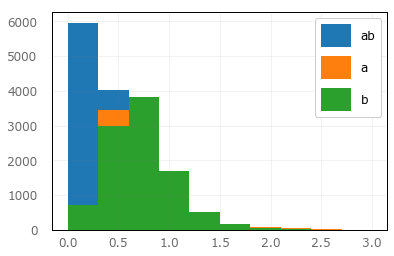

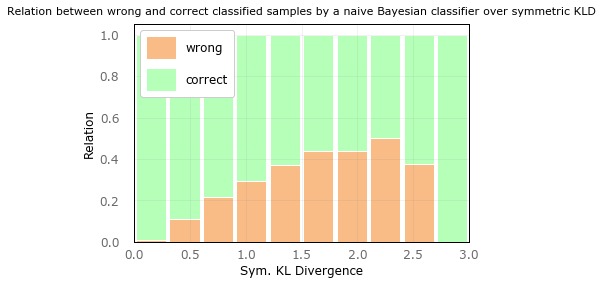

In [80]:
min = 0.
max = 3.
bins = 10
yx = plt.hist(kl_ab_ab.mean(axis=-1), bins, range=(min, max), label='ab')
yx_c = plt.hist(kl_ab_a.mean(axis=-1), bins, range=(min, max), label='a')
yx_w = plt.hist(kl_ab_b.mean(axis=-1), bins, range=(min, max), label='b')
plt.legend(loc='upper right')
plt.show()


_, ax = plt.subplots(1,1)
rel_bar_plot(kl_ab_b.mean(axis=-1), y_test, y_pred_ab_b, .0, 3., 10, ax)
ax.legend(loc='upper left')
ax.set_xlabel('Sym. KL Divergence')
ax.set_ylabel('Relation')
ax.set_title('Relation between wrong and correct classified samples by a naive Bayesian classifier over symmetric KLD')
plt.show()


### JS

In [71]:
loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
js = pickle.load( open( loc, "rb" ) )

#print(js)

# js structure:
# js = {'test_ab_vs_ab': js_d_ab,
#               'test_ab_vs_a': js_d_ab_a,
#               'test_ab_vs_b': js_d_ab_b,
#               'test_b_vs_a': js_d_b_a,
#               'train_ab_vs_ab': js_d_ab_train,
#               'train_ab_vs_a': js_d_ab_a_train,
#               'train_ab_vs_b': js_d_ab_b_train,
#               'train_b_vs_a': js_d_b_a_train}

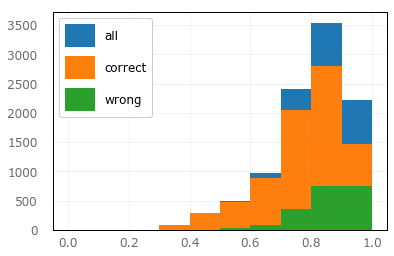

In [72]:
mw = js['test_ab_vs_b'][(y_test != y_pred_ab_b)]
mc = js['test_ab_vs_b'][(y_test == y_pred_ab_b)]
yx = plt.hist(js['test_ab_vs_b'], range=(.0, 1.), label='all')
yx_c = plt.hist(mc, range=(.0, 1.), label='correct')
yx_w = plt.hist(mw, range=(.0, 1.), label='wrong')
plt.legend(loc='upper left')
plt.show()

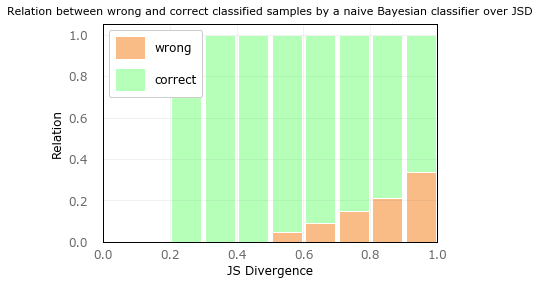

In [75]:
f, ax = plt.subplots()
rel_bar_plot(js['test_ab_vs_b'], y_test, y_pred_ab_b, 0.0, 1., 10, ax)
plt.legend(loc='upper left')
ax.set_xlim((0., 1.))
ax.set_xlabel('JS Divergence')
ax.set_ylabel('Relation')
plt.title('Relation between wrong and correct classified samples by a naive Bayesian classifier over JSD')
plt.show()

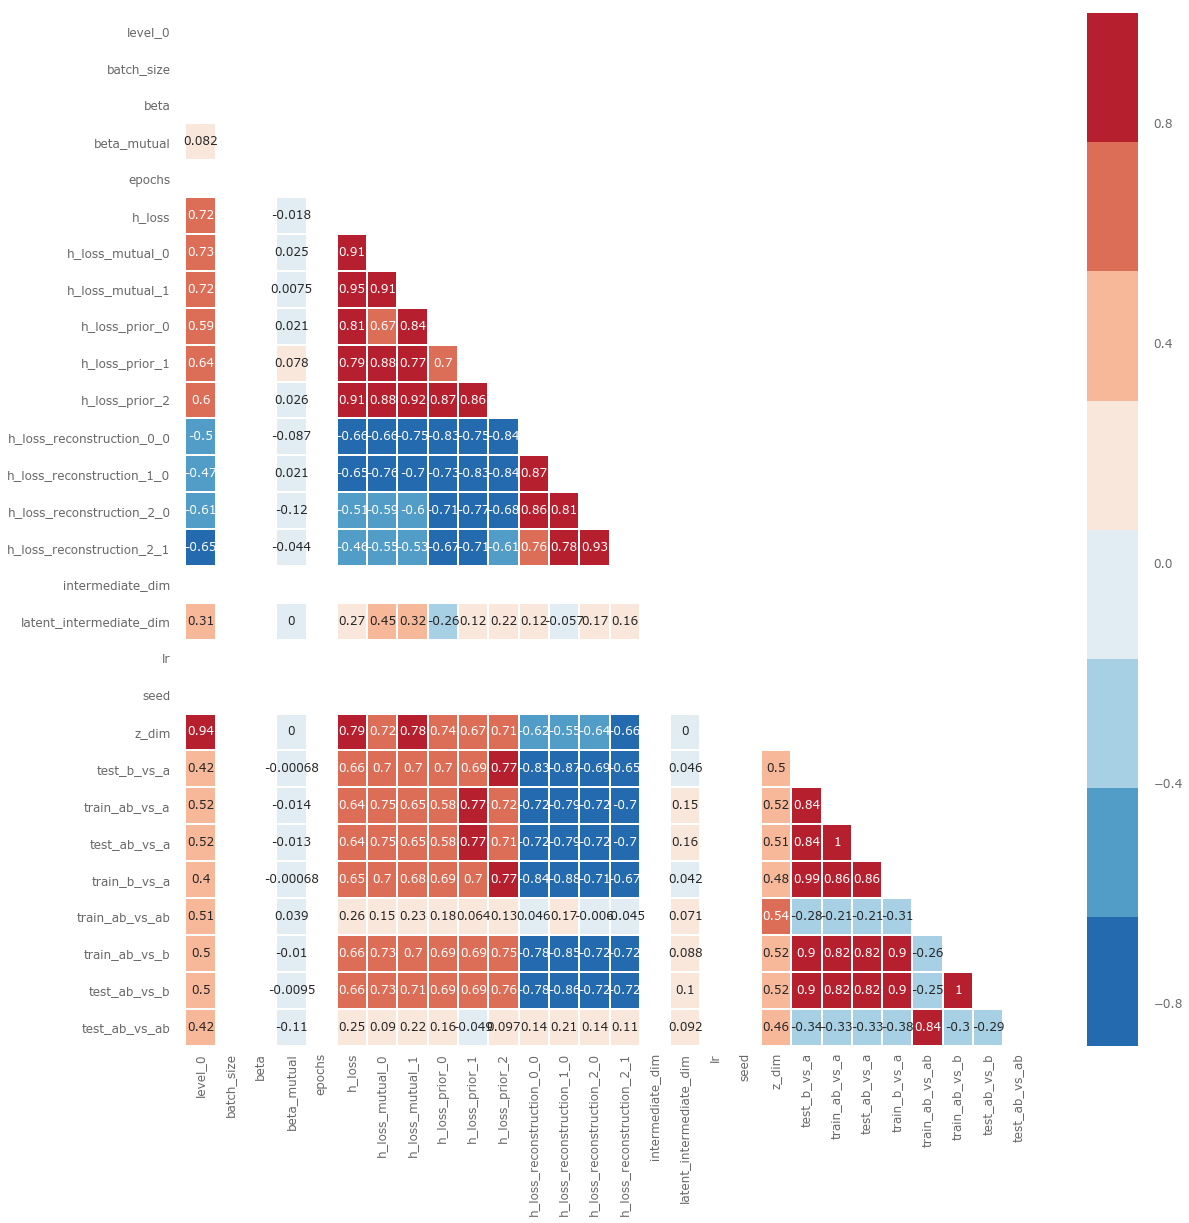

In [101]:

_df = df

jsd = None
for idx in df['index']:
    loc = dump_loc + 'jsd_' + str(idx) + '_ab.p'
    js = pickle.load( open( loc, "rb" ) )
    if jsd is None:
        jsd = {}
        for k in js.keys():
            jsd[k] = []
    for k in js.keys():
        #print(np.mean(js[k]))
        jsd[k].append(np.mean(js[k]))
# Add the JSD to the pandas data frame
__df = pd.DataFrame(jsd, columns=jsd.keys())
_df = pd.concat([_df, __df], axis =1).reset_index()
#_df = _df.append(jsd, ignore_index=True)

# correlation w/o validation
_df = _df.drop(["activation","reconstruction_loss_metrics","optimizer","index"], axis=1)
_df = _df[[c for c in _df.columns if c[:5] != 'h_val']]


astetik.corr(_df, color_grades=5, style='astetik', annot=True)
#_df